In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, LSTM, TimeDistributed
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from math import sqrt
import matplotlib.pyplot as plt

In [7]:
np.random.seed(7)
tf.random.set_seed(7)

In [10]:
csv_path = '/content/train.csv'
train = pd.read_csv(csv_path)

# Print columns to help diagnose if 'date' column is missing or misnamed
print("Columns in the DataFrame:", train.columns.tolist())

# The following lines caused a KeyError because 'date' column was not found.
# You may need to load a different dataset or adjust column names.
# train["date"] = pd.to_datetime(train["date"])

# Filtrar una serie (these lines also depend on 'store' and 'item' columns, which may also be missing)
# train = train.query("store == 1 and item == 1")
# train = train.sort_values("date")
train.head()
# print(len(train)) # This line might also need adjustment depending on your data

Columns in the DataFrame: ['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPo

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [12]:
def make_supervised_windows(series: np.ndarray, window:int,lag:int):
  X,y = [],[]
  for i in range(window, len(series)-lag):
    X.append(series[i-window:i])
    y.append(series[i+lag])
  return np.array(X), np.array(y)

window=26
lag=1

X,y= make_supervised_windows(train["SalePrice"].values,window,lag)
print("X", X.shape, "y", y.shape)

X (1433, 26) y (1433,)


In [14]:
#Division temporal y escalado
cut = int(len(X)*0.8)
X_train, X_test = X[:cut], X[cut:]
y_train, y_test = y[:cut], y[cut:]

scaler_x = StandardScaler().fit(X_train)
scaler_y = StandardScaler().fit(y_train.reshape(-1,1))

X_train_s=scaler_x.transform(X_train)
X_test_s=scaler_x.transform(X_test)
y_train_s=scaler_y.transform(y_train.reshape(-1,1)).ravel()
y_test_s=scaler_y.transform(y_test.reshape(-1,1)).ravel()

print("X_trainn_s ", X_train_s.shape, "y_train_s", y_train_s.shape)

X_train_3d = X_train_s.reshape((len(X_train_s), window, 1))
X_test_3d = X_test_s.reshape((len(X_test_s), window, 1))

print("Train_3d: ", X_train_3d.shape, "Test_3d: ", X_test_3d.shape)

X_trainn_s  (1146, 26) y_train_s (1146,)
Train_3d:  (1146, 26, 1) Test_3d:  (287, 26, 1)


In [17]:
#CNN 1D

model_cnn = Sequential([
    Conv1D(filters=32, kernel_size=2, activation="relu", input_shape=(window,1)),
  MaxPooling1D(pool_size=2),
  Flatten(),
  Dense(32, activation="relu"),
  Dense(1)
])
model_cnn.compile(optimizer="adam", loss="mse")
model_cnn.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_1 (Conv1D)               │ (None, 25, 32)         │            96 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 12, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 384)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │        12,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,449 (48.63 KB)

 Trainable params: 12,449 (48.63 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
history_cnn = model_cnn.fit(X_train_3d, y_train_s, epochs=50, batch_size=32, verbose=1)

Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.9973
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9060
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8939
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8790
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8636
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8474
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8328
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8183
Epoch 9/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8004
Epoch 10/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7854
Epoch 11/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7690
Epoch 12/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7493
Epoch 13/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7279
Epoch 14/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7079
Epoch 15/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6869
Epoch 16/50
36/36 ━

In [20]:
# Predictions
pred_cnn_s = model_cnn.predict(X_test_3d).ravel()
pred_cnn = scaler_y.inverse_transform(pred_cnn_s.reshape(-1,1)).ravel()
print("RMSE: ", sqrt(mean_squared_error(y_test, pred_cnn)))

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
RMSE:  108142.0198072886


In [21]:
#LSTM
model_lstm = Sequential([
    LSTM(32, activation="tanh", input_shape=(window+1,1)),
    Dense(1)
])
model_lstm.compile(optimizer="adam", loss="mse")
model_lstm.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 32)             │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,385 (17.13 KB)

 Trainable params: 4,385 (17.13 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
history_lstm = model_lstm.fit(X_train_3d, y_train_s, epochs=50, batch_size=32, verbose=1)

Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.9425
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.9363
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.9364
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.9366
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.9366
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.9366
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.9365
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.9365
Epoch 9/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.9364
Epoch 10/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.9364
Epoch 11/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.9363
Epoch 12/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.9363
Epoch 13/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.9362
Epoch 14/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.9361
Epoch 15/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.9360
Epoc

In [24]:
pred_lstm_s = model_lstm.predict(X_test_3d).ravel()
pred_lstm = scaler_y.inverse_transform(pred_lstm_s.reshape(-1,1)).ravel()
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, pred_lstm)):.4f}")

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
RMSE: 79031.4036


In [27]:
# CNN + LSTM
subseq = 2 # Changed to 2 to be a divisor of window=26
assert window % subseq == 0, "Window must be divisible by subseq"
steps_per_subseq = window // subseq

Xtr4 = X_train_3d.reshape((len(X_train_3d), subseq, steps_per_subseq, 1))
Xte4 = X_test_3d.reshape((len(X_test_3d), subseq, steps_per_subseq, 1))

model_cnn_lstm = Sequential([
    TimeDistributed(Conv1D(filters=32, kernel_size=3, activation="relu"),
                    input_shape=(subseq, steps_per_subseq, 1)),
    TimeDistributed(MaxPooling1D(pool_size=2)),
    TimeDistributed(Flatten()),
    LSTM(32, activation="tanh"),
    Dense(1)

  ])
model_cnn_lstm.compile(optimizer="adam", loss="mse")
model_cnn_lstm.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 2, 11, 32)      │           128 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 2, 5, 32)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 2, 160)         │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,865 (97.13 KB)

 Trainable params: 24,865 (97.13 KB)

 Non-trainable params: 0 (0.00 B)

In [28]:
history_cnn_lstm = model_cnn_lstm.fit(Xtr4,
                                      y_train_s,
                                      epochs=50,
                                      batch_size=32,
                                      verbose=1)

Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.9324
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.9256
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.9261
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.9252
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.9220
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.9177
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.9135
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.9087
Epoch 9/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.9027
Epoch 10/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.8956
Epoch 11/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.8875
Epoch 12/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.8784
Epoch 13/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.8681
Epoch 14/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.8563
Epoch 15/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.8424
Epoch 16/50
36/36

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step
RMSE CNN-LSTM: 100696.5209


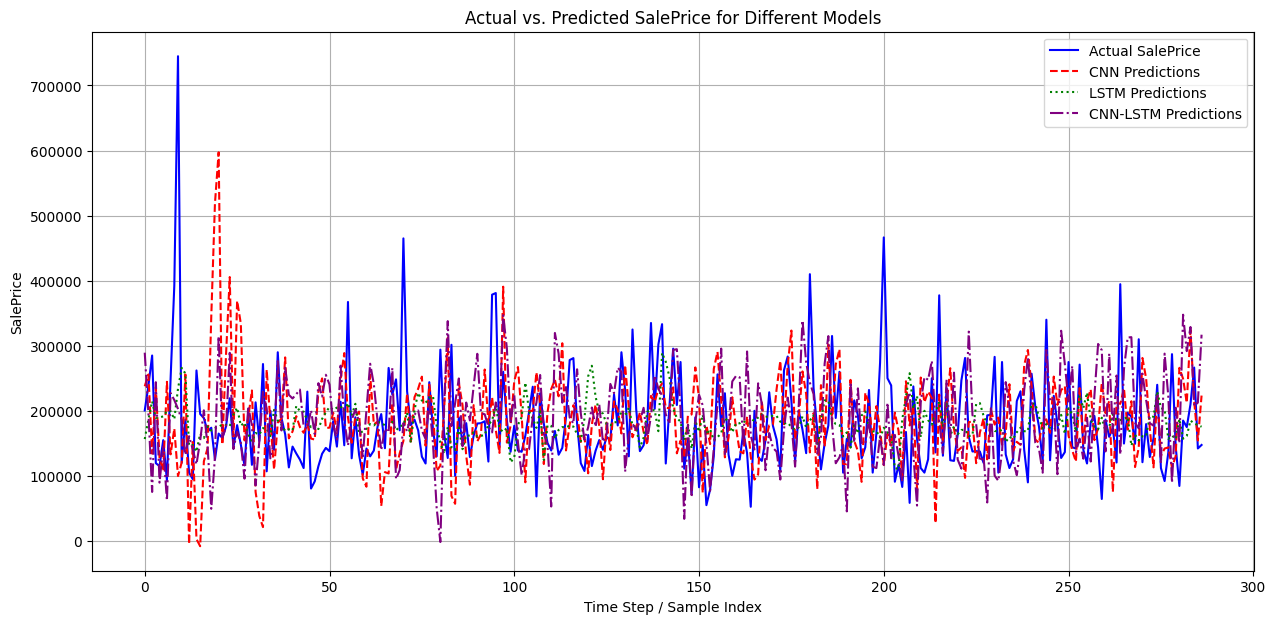

In [29]:
pred_cnn_lstm_s = model_cnn_lstm.predict(Xte4).ravel()
pred_cnn_lstm = scaler_y.inverse_transform(pred_cnn_lstm_s.reshape(-1,1)).ravel()
print(f"RMSE CNN-LSTM: {np.sqrt(mean_squared_error(y_test, pred_cnn_lstm)):.4f}")

plt.figure(figsize=(15, 7))
plt.plot(y_test, label='Actual SalePrice', color='blue')
plt.plot(pred_cnn, label='CNN Predictions', color='red', linestyle='--')
plt.plot(pred_lstm, label='LSTM Predictions', color='green', linestyle=':')
plt.plot(pred_cnn_lstm, label='CNN-LSTM Predictions', color='purple', linestyle='-.')
plt.title('Actual vs. Predicted SalePrice for Different Models')
plt.xlabel('Time Step / Sample Index')
plt.ylabel('SalePrice')
plt.legend()
plt.grid(True)
plt.show()